# Library

In [ ]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import scipy.io as sio
import glob as glob
import tensorflow
import seaborn as sns

from scipy import signal
from matplotlib import pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Add
from keras.layers import Conv2D, BatchNormalization, Permute
from keras.layers import SeparableConv2D, DepthwiseConv2D, AveragePooling2D
from keras.layers import Conv1D, Activation, Add
from keras import optimizers
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

from torch.nn import init
from torch.nn.functional import elu
from torch.autograd import Variable


# Pre-Processing


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
'''files description
	a01T -- Training dataset and label
  a0XE -- dataset for Evaluation  
  A0XE -- labels Evaluation dataset
'''
data_path = '/gdrive/My Drive/BCICIV_2a_mat/'

In [ ]:
def get_data(subject, training, path):
  '''load datasets
	subject -- number of subject in [1, .. ,9]
	training -- if True, load training data

  return: data, label, artifact,
  data -- (25,) array, dtype = float64
  label -- (288, 1) array, 1 to 4, dtype = int64
  trigger -- (288, 1) array
  artifact -- (288, 1) array, 0 or 1, dtype = int64
  eventtyp -- (, 1) array, only 769 to 772 are meaningful
  eventpos -- (, 1) array, position of event
  eventdur -- (, 1) array, duration of event
  '''
  if training:
    a = sio.loadmat(path+'a0'+str(subject)+'T.mat') # load subject EEG .mat file (master structure)
    # load the a0xT structure in the .mat file
    #[0, 0] to reduce structure dimension make other fields more accessable in this case
    adata = a['a0'+str(subject)+'T'][0, 0]
    label = np.reshape(adata['Classlabel'],-1).astype(np.int) # load label for each triggered event in the EEG file 
  else:
    a = sio.loadmat(path+'a0'+str(subject)+'E.mat') # load subject EEG .mat file (master structure)
    adata = a['a0'+str(subject)+'E'][0, 0] # load the a0xT structure in the .mat file
    label = sio.loadmat(path+'A0'+str(subject)+'E.mat')
    label = np.reshape(label['classlabel'],-1).astype(np.int)

  event = adata['EVENT'] # load event field in the EEG file 
  artifact = np.reshape(adata['ArtifactSelection'],-1).astype(np.int) # load event artifact in the EEG file 
  trigger = adata['TRIG'] # load trigger in the EEG file 
  data = adata['data'] # load trial data in the EEG file 
  data=np.transpose(data) # transpose the data so that temporal information is on x axis
  

  eventTYP = np.reshape(event['TYP'][0,0],-1).astype(np.int) # load the type of event in the 'EVENT' field
  eventPOS = np.reshape(event['POS'][0,0],-1).astype(np.int) # load the position of event in the 'EVENT' field
  eventDUR = np.reshape(event['DUR'][0,0],-1).astype(np.int) # load the duration of event in the 'EVENT' field

  return data, label, artifact, trigger, eventTYP, eventPOS, eventDUR


In [ ]:
def slice_events(typ, pos, dur, artifact, trigger, label):

  '''Remove invalid trials and corresponding label
	typ - type of event (e.g.: start trial, invalid trial, target movement.. etc): array, dtype = int64 
  pos - position of the event in the collected data: array, dtype = int64
  dur - during of the event/trials: array, dtype = int64
  artifact - rejected event index correspond to position of starting a trial - logical array 
  trigger - position where a trial begins in the collected data: array, dtype = int64
  label - label/class for each trials: array, dtype = int64

  return: valid_pos, valid_dur, y_label
  valid_pos -- position of the valid trial (remove invalid trials) in collect data: array, dtype = float64
  valid_dur -- duration of valid trial duration: : array, dtype = float64
  y_label -- valid trials' label: array, dtype = float64
  '''

  evt = np.where(typ == 768) # trial triggered indices 
  evtpos = pos[evt].astype(np.int) # event triggered posistion in time (start index for temporal information in EEG data)

  artEvent = np.where(artifact == 1) # indice of artifacts
  invalid_TRI = trigger[artEvent] # invalid triggered event
  invalid_evt = np.where(evtpos == invalid_TRI)[1] # find indices where there is invlid event
  valid_pos = np.delete(evtpos,invalid_evt) # remove invalid event from original event triggered posistion

  evtdur = dur[evt].astype(np.int) # triggered event duration (number index for temporal information in EEG data)
  valid_dur = np.delete(evtdur,invalid_evt) # remove invalid event from original event triggered duration

  y_label = np.delete(label,invalid_evt) # labels for triggered event
  
  return valid_pos, valid_dur, y_label

In [ ]:
def Subject_data_label(subject, path):

  '''generate training and testing data for subjects
	subject - subject number: int (1 - 9)
  path - path of the data: str

  return: X_train, y_train_ohe, X_test, y_test_ohe
  X_train -- normalized training data : 3x1 matrix, dtype: float64
  y_train_ohe -- one hot encoded label for training data: 1x4 matrix, dtype: int64
  X_test -- normalized testing data: 3x1 matrix, dtype: float64
  y_test_ohe -- one hot encoded label for testing data: 1x4 matrix, dtype: int64
  '''
  
#Training dataset
  [data, label, artifact, trigger, eventTYP, eventPOS, eventDUR] = get_data(subject, True, data_path)
  [valid_pos, valid_dur, y_label] = slice_events(eventTYP, eventPOS, eventDUR, artifact, trigger, label)

  X_train = np.zeros((len(valid_pos), 22, max(valid_dur))) #initilized an array for EEG data
  Y_train = np.zeros(len(valid_pos)) #initilized an array for EEG label

  for i, event_trig in enumerate(valid_pos):
    X_train[i,:, :] = data[0:22, event_trig : event_trig + valid_dur[i]] # Extract valid channel and trials - training
    Y_train[i] = y_label[i] # valid trials label - training
  
  X_train = X_train[:,np.newaxis, :, :] # add extra dimension to EEG training data
  y_train_ohe = to_categorical(Y_train - 1) # convert training label to one hot encode

# Evaluation dataset
  [data, label, artifact, trigger, eventTYP, eventPOS, eventDUR] = get_data(subject, False, data_path)
  [valid_pos, valid_dur, y_label] = slice_events(eventTYP, eventPOS, eventDUR, artifact, trigger, label)

  X_test = np.zeros((len(valid_pos), 22, max(valid_dur))) #initilized an array for EEG data
  Y_test = np.zeros(len(valid_pos)) #initilized an array for EEG label

  for i, event_trig in enumerate(valid_pos):
    X_test[i,:, :] = data[0:22, event_trig : event_trig + valid_dur[i]] # Extract valid channel and trials - testing
    Y_test[i] = y_label[i] # valid trials label - testing

  X_test = X_test[:,np.newaxis, :, :] # add extra dimension to EEG testing data
  y_test_ohe = to_categorical(Y_test - 1) # convert testing label to one hot encode

  # normalize training and testing data 
  for j in range(22):
    scaler = StandardScaler()
    scaler.fit(X_train[:,0,j,:])
    X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
    X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])

  return X_train, y_train_ohe, X_test, y_test_ohe, Y_train, Y_test

# Multi-Layer CNN Model

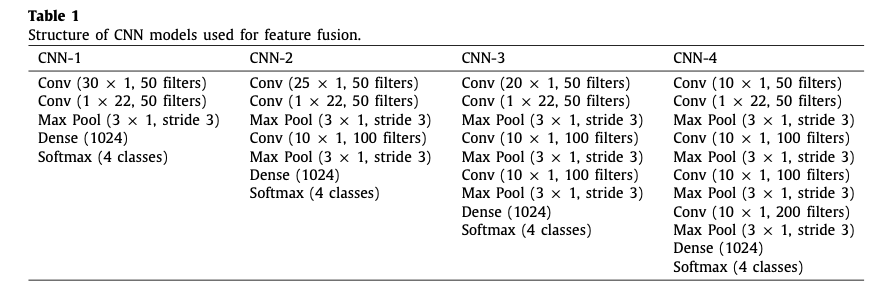

In [ ]:

# CNN model with an adjustable number of convolution blocks. Scripted in PyTorch

class CNN(nn.Module):
  def __init__(self, input_size,filter_size,num_blocks):
    super(CNN,self).__init__()
    # num_blocks = Number of additional convolution blocks to be added
    self.num_blocks = num_blocks
    # 2D convolution across time samples
    self.conv_temporal = nn.Conv2d(1,50,(1,filter_size),stride=1,bias=False,
                                   padding=1)
    # 2D convolution: spatial filtering with weights for all possible pairs of 
    # electrodes with filters of the preceding temporal convolution
    self.conv_spatial = nn.Conv2d(50,50,(input_size,1),stride=(1, 1),bias=False,
                                  padding=1)
    # Batch normalization
    self.bnorm = nn.BatchNorm2d(50,momentum=0.1,affine=True,eps=1e-5)
    # ELU activation function
    self.elu = nn.ELU()
    # Max pooling
    self.pool = nn.MaxPool2d(kernel_size=(1,3), stride=(1,3))

    # Add a convolution block to the network. The block consists of a dropout
    # layer, 2D convolution, batch normalization, ELU activation function, and a
    # max pooling layer
    self.md = nn.ModuleDict({})
    def add_conv_pool_block(self,n_filters_in,n_filters_out,block_num):
      num = block_num
      self.md["drop{:d}".format(num)] = nn.Dropout(0.5)
      self.md["conv{:d}".format(num)] = nn.Conv2d(n_filters_in,n_filters_out,(1,10),
                            stride=(1, 1), bias=False,padding=1)
      self.md["bnorm{:d}".format(num)] = nn.BatchNorm2d(n_filters_out,momentum=0.1,
                               affine=True,eps=1e-5)
      self.md["elu{:d}".format(num)] = nn.ELU()
      self.md["pool{:d}".format(num)] = nn.MaxPool2d(
                  kernel_size=(1,3), stride=(1,3))
      
      
    # Add x conv/pool blocks where x = num_blocks (x can be up to 3)
    n_filters_in = 50
    n_filters_out = 100
    for i in range(self.num_blocks):
      if (i+1) == 3:
        n_filters_out = 200
      add_conv_pool_block(self, n_filters_in, n_filters_out,i)
      n_filters_in = n_filters_out

    inp = 616
    if self.num_blocks == 0:
      inp = 616
    elif self.num_blocks == 1:
      inp = 203
    elif self.num_blocks == 2:
      inp = 65
    elif self.num_blocks == 3:
      inp = 19    
    # Dropout layer 
    self.drop_last = nn.Dropout(0.5)
    # Linear layer and classifier
    self.dense = nn.Linear(inp,16)
    self.classifier = nn.Linear(16,4)
    
    self.init_weights()
    
    
  def init_weights(self):
    init.xavier_uniform_(self.conv_temporal.weight, gain=1)
    init.xavier_uniform_(self.conv_spatial.weight, gain=1)
    init.constant_(self.bnorm.weight, 1)
    init.constant_(self.bnorm.bias, 0)

    for i in range(self.num_blocks):
      init.xavier_uniform_(self.md["conv{:d}".format(i)].weight, gain=1)
      init.constant_(self.md["bnorm{:d}".format(i)].weight, 1)
      init.constant_(self.md["bnorm{:d}".format(i)].bias, 0)
    
    init.xavier_uniform_(self.dense.weight, gain=1)
    init.xavier_uniform_(self.classifier.weight, gain=1)
    init.constant_(self.classifier.bias, 0)

  def forward(self,x):
    x = self.conv_temporal(x)
    x = self.conv_spatial(x)
    x = self.bnorm(x)
    x = self.elu(x)
    x = self.pool(x)

    for i in range(self.num_blocks):
      dropx = self.md["drop{:d}".format(i)]
      x = dropx(x)
      convx = self.md["conv{:d}".format(i)]
      x = convx(x)
      bnormx = self.md["bnorm{:d}".format(i)]
      x = bnormx(x)
      elux = self.md["elu{:d}".format(i)]
      x = elux(x)
      poolx = self.md["pool{:d}".format(i)]
      x = poolx(x)

    x = self.drop_last(x)
    x = torch.mean(x, x.ndimension()-2)
    x = torch.mean(x, x.ndimension()-2)

    x = self.dense(x)
    x = self.classifier(x)
    
    return x

In [ ]:
class MLP(nn.Module):
  # Multi-layer perceptron with 2 hidden layers and dropout = 0.5
  def __init__(self):
    super(MLP,self).__init__()
    self.h1 = nn.Linear(16, 50)
    self.drop1 = nn.Dropout(0.5)
    self.elu = nn.ELU()
    self.h2 = nn.Linear(50, 4)
    self.drop2 = nn.Dropout(0.5)
    self.softmax = nn.LogSoftmax(dim=1)

    self.layers = nn.Sequential(
        self.h1,self.drop1,self.elu,self.h2,self.drop2,self.softmax)
    self.init_weights()

  def init_weights(self):
      init.xavier_uniform_(self.h1.weight)
      init.xavier_uniform_(self.h2.weight)

  def forward(self, x):
    return self.layers(x)

In [ ]:
class MCNN(nn.Module):
  def __init__(self,input_size,filter_size1,filter_size2,
               filter_size3,filter_size4):
    super(MCNN,self).__init__()
    # MCNN concatenates features of CNN's 1-4 as input to a MLP
    # with 2 hidden layers. MLP classifies MI state from these combined outputs
    self.cnn1 = CNN(input_size,filter_size=filter_size1,num_blocks=0)
    self.cnn2 = CNN(input_size,filter_size=filter_size2,num_blocks=1)
    self.cnn3 = CNN(input_size,filter_size=filter_size3,num_blocks=2)
    self.cnn4 = CNN(input_size,filter_size=filter_size4,num_blocks=3)
    self.mlp = MLP()
  
  def forward(self,input1,input2,input3,input4):
    c1 = self.cnn1(input1)
    c2 = self.cnn2(input2)
    c3 = self.cnn3(input3)
    c4 = self.cnn4(input4)
    combined = torch.cat((c1,c2,c3,c4), dim=1)
    out = self.mlp(combined)

    return out

In [ ]:
# Parameters for MCNN
input_size = 22
filter_size1 = 30
filter_size2 = 25
filter_size3 = 20
filter_size4 = 10
batch_size = 32

In [ ]:
def MCNNevaluate(model, X, Y):
    model.eval()
    with torch.no_grad():
      results = []
      batch_size = 32
      accuracy = []
      predicted = []
      lab = []
    
      for i in range(int(len(X)/batch_size-1)):
          s = i*batch_size
          e = i*batch_size+batch_size

          inputs = Variable(torch.from_numpy(X[s:e]).to(device))
          labels = Variable(torch.LongTensor(np.array([Y[s:e]])).to(device))
          labels = torch.sub(labels,1)
          labels = torch.squeeze(labels)
          pred = model(inputs,inputs,inputs,inputs)
          predicted = torch.argmax(pred.data,1)
          correct = (predicted == labels).float()
          acc = correct.sum() / len(correct)
          acc = torch.round(acc * 100)
          accuracy.append(acc.cpu().numpy())

      meanacc = np.mean(np.asarray(accuracy))

      return meanacc
    model.train()

In [ ]:
def train(model):
  if torch.cuda.is_available():
    model.to(device)
    criterion = nn.NLLLoss().to(device)
  optimizer = optim.Adam(model.parameters(),lr=1e-4)
  #loss_values = []
  #acc_values = []
  for epoch in range(100):  # loop over the dataset multiple times
      print("\nEpoch ", epoch)
      
      running_loss = 0.0
      for i in range(int(len(X_train)/batch_size-1)):
        # zero the parameter gradients
          optimizer.zero_grad()
          s = i*batch_size
          e = i*batch_size+batch_size
          
          inputs = torch.from_numpy(X_train[s:e])
          labels = torch.LongTensor(np.array([Y_train[s:e]]))
          labels = torch.sub(labels,1)

          # wrap them in Variable
          inputs, labels = Variable(inputs), Variable(labels)
          inputs, labels = inputs.to(device), labels.to(device)

          

          # forward + backward + optimize
          outputs = model(inputs,inputs,inputs,inputs) 

          loss = criterion(outputs,
                          torch.squeeze(labels))
          loss.backward()
          
          
          optimizer.step()
          
          running_loss += float(loss.item())
      #loss_values.append(running_loss/len(X_train))

      print("Training Loss ", running_loss)
      acc = MCNNevaluate(model, X_train, Y_train)
      print('Accuracy:',acc)
      #acc_values.append(acc)

In [ ]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
  torch.cuda.set_device(0)
  device = torch.device('cuda')

accuracy = np.zeros(9)

for subject in range(1, 10):
  print('Subject', subject)
  [X_train, y_train_ohe, X_test, y_test_ohe, Y_train, Y_test] = Subject_data_label(subject, data_path) 
  X_train = X_train.astype(np.float32)
  X_test = X_test.astype(np.float32)

  # Training
  model = MCNN(input_size,filter_size1,filter_size2,filter_size3,filter_size4)
  train(model)

  # Testing
  scores = MCNNevaluate(model,X_test,Y_test)
  accuracy[subject-1] = scores

Subject 1

Epoch  0
Training Loss  13.509974598884583
Accuracy: 24.285715

Epoch  1
Training Loss  9.76408588886261
Accuracy: 24.571428

Epoch  2
Training Loss  9.737557172775269
Accuracy: 25.571428

Epoch  3
Training Loss  9.718188166618347
Accuracy: 28.571428

Epoch  4
Training Loss  9.702032446861267
Accuracy: 24.571428

Epoch  5
Training Loss  9.687242150306702
Accuracy: 26.714285

Epoch  6
Training Loss  9.672785878181458
Accuracy: 27.142857

Epoch  7
Training Loss  9.6581472158432
Accuracy: 27.142857

Epoch  8
Training Loss  9.643036842346191
Accuracy: 26.714285

Epoch  9
Training Loss  9.627226114273071
Accuracy: 27.714285

Epoch  10
Training Loss  9.610470175743103
Accuracy: 27.714285

Epoch  11
Training Loss  9.59257698059082
Accuracy: 29.714285

Epoch  12
Training Loss  9.573274493217468
Accuracy: 30.142857

Epoch  13
Training Loss  9.552266001701355
Accuracy: 31.571428

Epoch  14
Training Loss  9.5291748046875
Accuracy: 33.142857

Epoch  15
Training Loss  9.50353717803955
Ac

In [ ]:
accuracy

array([39.8571434 , 28.1428566 , 35.57143021, 28.16666603, 32.        ,
       29.79999924, 35.2857132 , 35.42856979, 26.        ])

In [ ]:
def train_loss_and_accuracy(model):
  if torch.cuda.is_available():
    model.to(device)
    criterion = nn.NLLLoss().to(device)
  optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=0.01)
  loss_values = []
  acc_values = []
  for epoch in range(100):  # loop over the dataset multiple times
      print("\nEpoch ", epoch)
      
      running_loss = 0.0
      for i in range(int(len(X_train)/batch_size-1)):
          # zero the parameter gradients
          optimizer.zero_grad()
          s = i*batch_size
          e = i*batch_size+batch_size
          
          inputs = torch.from_numpy(X_train[s:e])
          labels = torch.LongTensor(np.array([Y_train[s:e]]))
          labels = torch.sub(labels,1)

          # wrap them in Variable
          inputs, labels = Variable(inputs), Variable(labels)
          inputs, labels = inputs.to(device), labels.to(device)

          

          # forward + backward + optimize
          outputs = model(inputs,inputs,inputs,inputs) 

          loss = criterion(outputs,
                          torch.squeeze(labels))
          loss.backward()
          
          
          optimizer.step()
          
          running_loss += float(loss.item())

      loss_values.append(running_loss/len(X_train))
      acc = MCNNevaluate(model, X_train, Y_train)
      acc_values.append(acc)
  return loss_values, acc_values


Epoch  0

Epoch  1

Epoch  2

Epoch  3

Epoch  4

Epoch  5

Epoch  6

Epoch  7

Epoch  8

Epoch  9

Epoch  10

Epoch  11

Epoch  12

Epoch  13

Epoch  14

Epoch  15

Epoch  16

Epoch  17

Epoch  18

Epoch  19

Epoch  20

Epoch  21

Epoch  22

Epoch  23

Epoch  24

Epoch  25

Epoch  26

Epoch  27

Epoch  28

Epoch  29

Epoch  30

Epoch  31

Epoch  32

Epoch  33

Epoch  34

Epoch  35

Epoch  36

Epoch  37

Epoch  38

Epoch  39

Epoch  40

Epoch  41

Epoch  42

Epoch  43

Epoch  44

Epoch  45

Epoch  46

Epoch  47

Epoch  48

Epoch  49

Epoch  50

Epoch  51

Epoch  52

Epoch  53

Epoch  54

Epoch  55

Epoch  56

Epoch  57

Epoch  58

Epoch  59

Epoch  60

Epoch  61

Epoch  62

Epoch  63

Epoch  64

Epoch  65

Epoch  66

Epoch  67

Epoch  68

Epoch  69

Epoch  70

Epoch  71

Epoch  72

Epoch  73

Epoch  74

Epoch  75

Epoch  76

Epoch  77

Epoch  78

Epoch  79

Epoch  80

Epoch  81

Epoch  82

Epoch  83

Epoch  84

Epoch  85

Epoch  86

Epoch  87

Epoch  88

Epoch  89

Epoch  90

Epoch  9

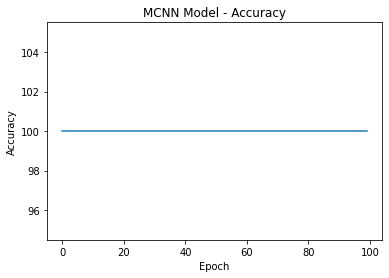

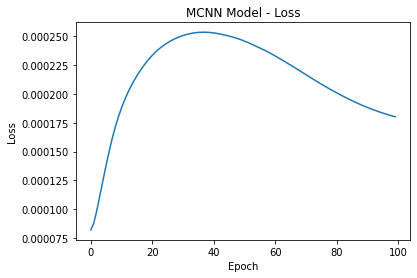

In [ ]:
train_loss, train_acc = train_loss_and_accuracy(model)
fig1, ax_acc = plt.subplots()
plt.plot(train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MCNN Model - Accuracy')
plt.show()
    
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MCNN Model - Loss')
plt.plot(train_loss)
plt.show()